In [51]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import random

In [52]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other ** -1
    
    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Exponent must be a scalar"
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other): # other - self
        return other + (-self)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def backward(self):
        topo_order = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo_order.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo_order):
            node._backward()
    
    

In [53]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

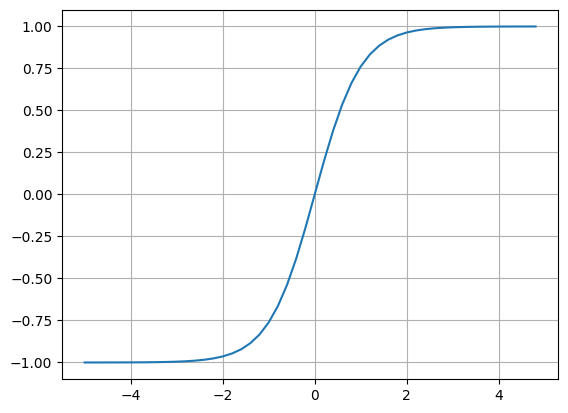

In [54]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [55]:
#Manual calculation of gradients

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

# Manually set the gradients
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# n.grad = 0.5
# o.grad = 1.0

# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad


In [56]:
#calc gradient each node manually
# o.grad = 1.0

# o._backward()

# n._backward()

# b._backward()

# x1w1x2w2._backward()

# x1w1._backward()

# x2w2._backward()

In [57]:
o.backward()


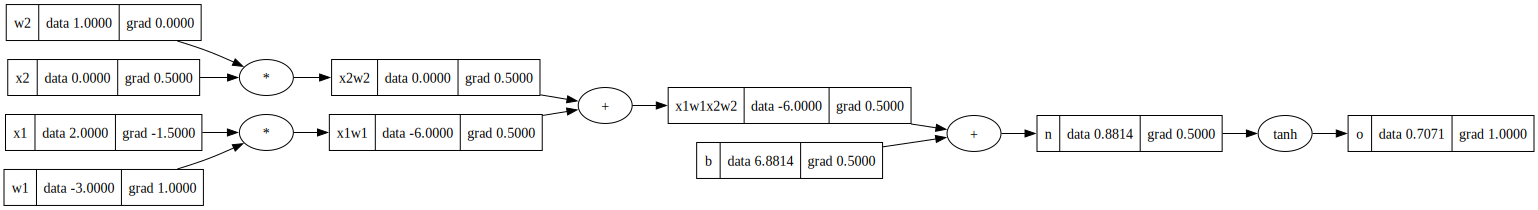

In [58]:
# Print the graph
dot = draw_dot(o)
dot.render('graph')
draw_dot(o)

In [59]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1)/(e + 1); o.label = 'o' ###Tanh definition 
o.backward()

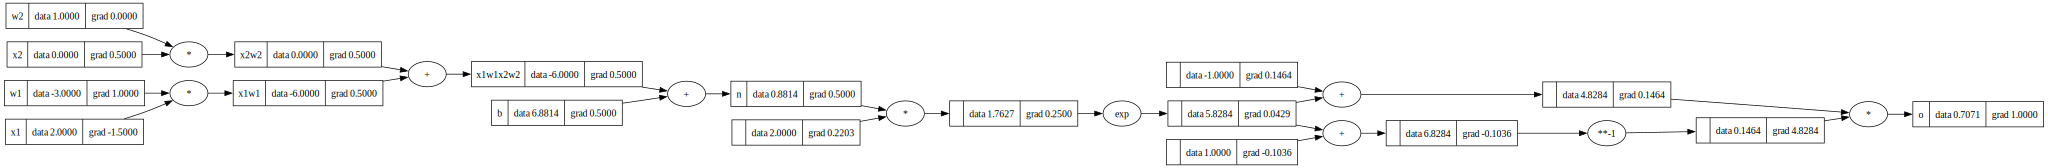

In [60]:
# Print the graph
dot = draw_dot(o)
dot.render('graph')
draw_dot(o)

In [61]:
###Same implementation with PyTorch
import torch

In [62]:
import torch

x1 = torch.Tensor([2.0]).double()  ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()  ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()  ; w2.requires_grad = True
b = torch.Tensor([6.881375870517954322]).double()  ; b.requires_grad = True

h = x1*w1 + x2*w2 + b
o = torch.tanh(h)

print(o.data.item())
o.backward()

print('---')
print('w2',w2.grad.item())
print('w1',w1.grad.item())
print('b',b.grad.item())
print('x1',x1.grad.item())

torch.Tensor([[1, 2, 3], [4, 5, 6]])


0.7071078824962277
---
w2 0.0
w1 0.999996885023402
b 0.499998442511701
x1 -1.499995327535103


tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [63]:

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        # w * x + b
        activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]    
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
    


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

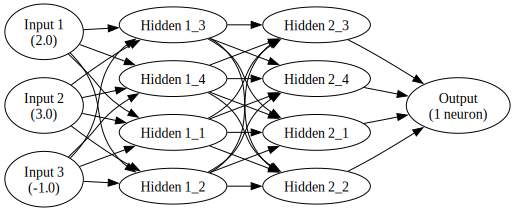

In [ ]:
""""x = [2.0, 3.0, -1.0]
    n = MLP(3, [4, 4, 1])
    output = n(x)
    print(output)
    
    This code generate a 3 input neurons
    MLP with 3 hidden layers of 4 neurons each and
    1 output neuron.
    """

dot = Digraph(comment='Network')

dot.attr(rankdir='LR')

dot.node('input1', 'Input 1\n(2.0)')
dot.node('input2', 'Input 2\n(3.0)')
dot.node('input3', 'Input 3\n(-1.0)')

dot.node('hidden1_1', 'Hidden 1_1')
dot.node('hidden1_2', 'Hidden 1_2')
dot.node('hidden1_3', 'Hidden 1_3')
dot.node('hidden1_4', 'Hidden 1_4')

dot.node('hidden2_1', 'Hidden 2_1')
dot.node('hidden2_2', 'Hidden 2_2')
dot.node('hidden2_3', 'Hidden 2_3')
dot.node('hidden2_4', 'Hidden 2_4')

dot.node('output', 'Output\n(1 neuron)')

# Agregar las aristas como tuplas (tail, head)
edges = [
    ('input1', 'hidden1_1'), ('input1', 'hidden1_2'), ('input1', 'hidden1_3'), ('input1', 'hidden1_4'),
    ('input2', 'hidden1_1'), ('input2', 'hidden1_2'), ('input2', 'hidden1_3'), ('input2', 'hidden1_4'),
    ('input3', 'hidden1_1'), ('input3', 'hidden1_2'), ('input3', 'hidden1_3'), ('input3', 'hidden1_4'),
    ('hidden1_1', 'hidden2_1'), ('hidden1_1', 'hidden2_2'), ('hidden1_1', 'hidden2_3'), ('hidden1_1', 'hidden2_4'),
    ('hidden1_2', 'hidden2_1'), ('hidden1_2', 'hidden2_2'), ('hidden1_2', 'hidden2_3'), ('hidden1_2', 'hidden2_4'),
    ('hidden1_3', 'hidden2_1'), ('hidden1_3', 'hidden2_2'), ('hidden1_3', 'hidden2_3'), ('hidden1_3', 'hidden2_4'),
    ('hidden1_4', 'hidden2_1'), ('hidden1_4', 'hidden2_2'), ('hidden1_4', 'hidden2_3'), ('hidden1_4', 'hidden2_4'),
    ('hidden2_1', 'output'), ('hidden2_2', 'output'), ('hidden2_3', 'output'), ('hidden2_4', 'output')
]

dot.edges(edges)
display(dot)


In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
output = n(x)
print(output)

Value(0.8180915301186684)


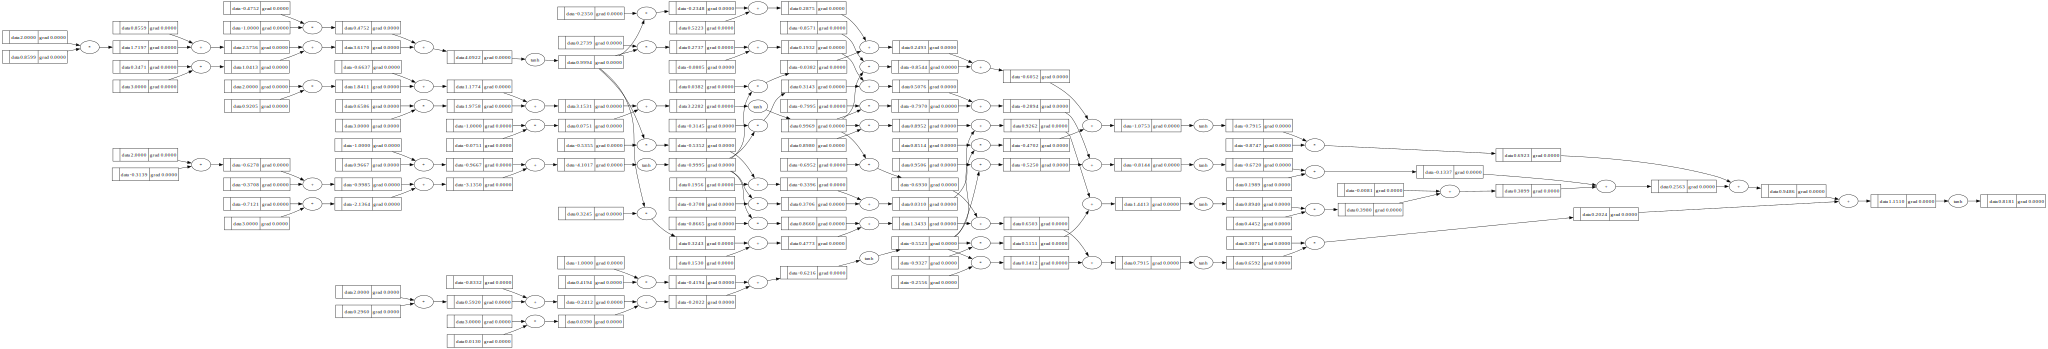

In [ ]:
draw_dot(output)

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]  # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(0.8180915301186684),
 Value(0.2520098765658058),
 Value(0.3927569811591234),
 Value(0.8210537915510169)]

In [ ]:
MSE= [(yout-ygt)**2 for ygt, yout in zip(ys, ypred)]

loss = sum(MSE)
loss

Value(3.5724131765186335)

In [ ]:
loss.backward()


In [ ]:
n.layers[0].neurons[0].w[0].grad

0.059535846060111544

In [69]:
# Perform a simple parameter update
learning_rate = 0.1
for p in n.parameters():
    p.data -= learning_rate * p.grad

# Clear gradients after update
for p in n.parameters():
    p.grad = 0.0

# Print updated parameters to verify
for p in n.parameters():
    print(p)


Value(1.371301263604174)
Value(0.23903866213673242)
Value(0.6808670719931722)
Value(0.5847744632602208)
Value(0.07951167979070713)
Value(-0.6726540836506075)
Value(0.7690766470362405)
Value(0.6309830899138897)
Value(-0.017128701877409308)
Value(-0.3317308669308773)
Value(0.8335392402979911)
Value(0.7387628236249609)
Value(0.022254953598487448)
Value(0.40143157968143367)
Value(-0.07421318673496083)
Value(-0.6595040014332728)
Value(-0.10118348883604979)
Value(-0.4788211669489199)
Value(0.4964404304476051)
Value(-0.5665017794317755)
Value(-1.0454843672653256)
Value(-0.2102099597597999)
Value(-0.24842591676098127)
Value(0.34088846610638796)
Value(-0.6888267866513524)
Value(0.06032282703770525)
Value(-0.7599517671717104)
Value(-0.3114359355198301)
Value(0.30304528997817426)
Value(0.8671230797202876)
Value(-0.8800298619773228)
Value(-0.15868677862075498)
Value(0.015529164956913422)
Value(-0.3034391514432008)
Value(-0.6213765258968118)
Value(-0.24962288582682524)
Value(-0.7434282815157992)
Va

In [70]:
for k in range(20):
    # Paso hacia adelante
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # Paso hacia atrás
    loss.backward()
    
    # Actualización de parámetros
    for p in n.parameters():
        p.data -= 0.05 * p.grad
    
    # Imprimir la pérdida
    print(k, loss.data)

0 4.31865733086578
1 1.8975931361912577
2 1.091210803315366
3 0.1324409291817278
4 0.01609429819609131
5 0.0022752420084592223
6 0.00034409378865536276
7 5.429707564651775e-05
8 8.840200715238423e-06
9 1.4789921929944326e-06
10 2.5496211324650696e-07
11 4.5838488830852904e-08
12 8.859727130061248e-09
13 1.985112420558495e-09
14 6.218652229155032e-10
15 3.967355462934511e-10
16 8.204742750782427e-10
17 8.77041388873475e-09
18 7.278292808934541e-07
19 0.0003225314726107442


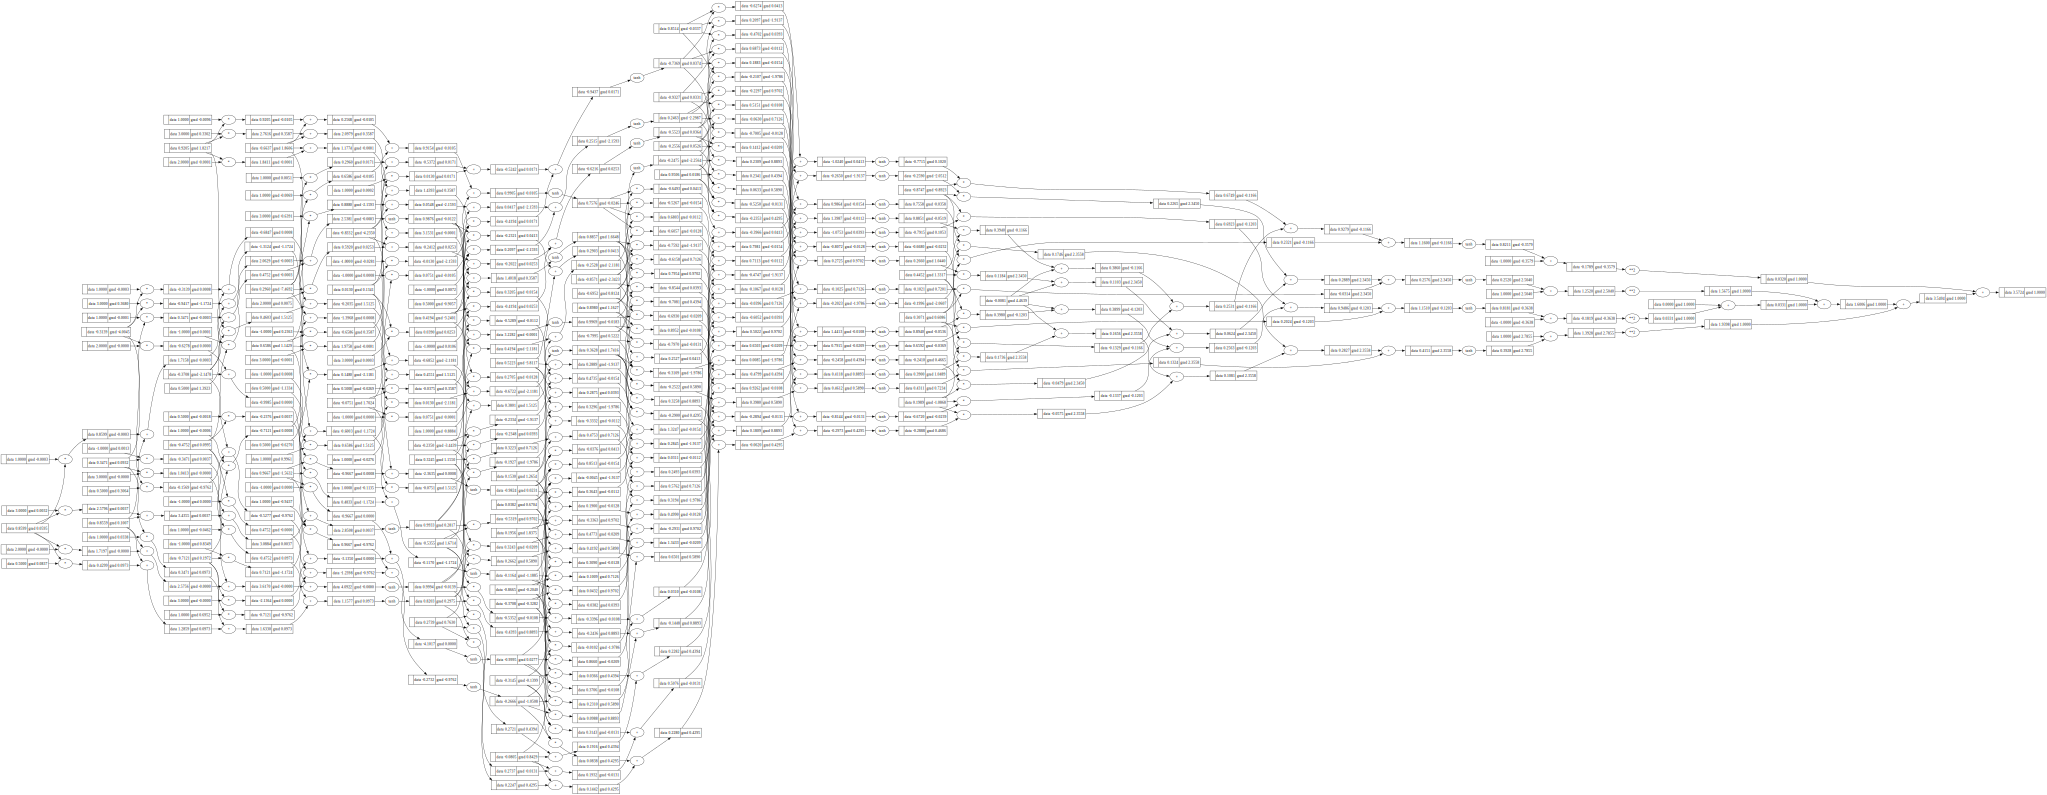

In [ ]:
dot = draw_dot(loss)
display(dot)